# Nonlinear regression for inverse dynamics

In this question, we fit a model which can predict what torques a robot needs to apply in order to make its arm reach a desired point in space. The data was collected from a SARCOS robot arm with $7$ degrees of freedom. The input vector $x \in \mathbb{R}^{21}$ encodes the desired position, velocity and accelaration of the $7$ joints. The output vector $y \in \mathbb{R}^7$ encodes the torques that should be applied to the joints to reach that point. The mapping from $x$ to $y$ is highly nonlinear.

We can find the data at [http://www.gaussianprocess.org/gpml/data/](http://www.gaussianprocess.org/gpml/data/). Obviously the first step is to read this data.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from util import read_all_sarcos_data, TARGET_COLUMN

training_data, test_data = read_all_sarcos_data()
training_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x19,x20,x21,y1,y2,y3,y4,y5,y6,y7
0,0.019478,-0.134218,0.027439,1.516401,0.300936,0.058259,0.150134,-0.266791,-0.237134,-0.091272,...,11.695956,1.210212,-22.119289,50.292652,-36.971897,20.937170,47.821712,-0.424812,-0.907553,8.090739
1,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,14.643369,1.015070,-17.048688,44.104164,-28.851845,16.230194,43.194073,-0.228739,-1.235817,7.762475
2,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,15.467628,0.910548,-11.415526,37.354858,-20.809343,12.379975,39.386017,0.244491,-1.700880,7.289678
3,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,10.309203,0.921360,-5.772058,30.676065,-13.963816,7.702940,36.478813,-0.182062,-2.143370,6.410800
4,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,2.868096,1.059957,-0.491542,25.920128,-11.178479,5.643934,34.773911,-1.031687,-2.355776,5.792892


Let's standardize our data by making each column have mean $0$ and unit variance.

## Linear Regression

Now, the first order of business is to fit a standard linear regression. I'll just use the `sklearn` implementation.

In [2]:
from sklearn import preprocessing
def standardize_data(data):
    feature_column_names = [column_name for column_name in all_data.columns if 'x' in column_name]
    features = data[feature_column_names]
    # only care about the first output for this problem
    target = data[TARGET_COLUMN]
    X = features.as_matrix()
    Y = target.as_matrix()
    X_scaled = preprocessing.scale(X, axis = 0, with_mean = True, with_std = True, copy = True)
    # only standardize inputs
    # Y_scaled = preprocessing.scale(Y, axis = 0, with_mean = True, with_std = True, copy = True)
    return X_scaled, Y
# standardize together and separate
all_data = pd.concat([training_data, test_data], axis = 0)
standardize_data(all_data)
X, Y = standardize_data(all_data)
X_scaled, Y_scaled = X[:len(training_data)], Y[:len(training_data)]
X_scaled_test, Y_scaled_test = X[len(training_data):], Y[len(training_data):]

In [3]:
from sklearn import linear_model
## since data is already normalized
linearRegressor = linear_model.LinearRegression(fit_intercept = True, normalize = False)
linearRegressor.fit(X_scaled, Y_scaled)
linearRegressor.score(X_scaled_test, Y_scaled_test)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.92494581827142286

According to the problem, we should be able to get a standardized mean squared error (SMSE) of 0.075. We define

\begin{equation}
SMSE = \left(\frac{1}{N_{test}}\sum_{i=1}^{N_{test}}\left(y_i - \hat{y}_i\right)^2\right)/\sigma^2,
\end{equation}

where 

\begin{equation}
\sigma^2 = \frac{1}{N_{train}}\sum_{i=1}^{N_{train}}\left(y_i - \bar{y}\right)^2.
\end{equation}

In [4]:
def compute_mse(prediction, labels):
    return (sum((labels - prediction)**2)/len(prediction))
def compute_model_mse(model, X, y):
    predicted_y = model.predict(X)
    return compute_mse(predicted_y, y)
def log_mse(mse):
    print('MSE: {:.10f}'.format(mse))
    print('SMSE: {:.10f}'.format(mse/np.var(Y_scaled, ddof = 0)))

test_mse = compute_model_mse(linearRegressor, X_scaled_test, Y_scaled_test)

log_mse(test_mse)

MSE: 31.0857592861
SMSE: 0.0742260930


Looks like we got the correct result. Yay! 

Next, we'll try using a radial basis function (RBF) network. First, we need to do some K-means clustering. We'll pick the number of clusters with the qualitative kink, knee, or elbow method (three different names for the same method). The book says to use cross-validation, but that's nonsense since the book itself says that using cross-validation is not possible for non-probablistic methods. I guess we could use a Gaussian Mixture Model if we want to do cross-validation?

We'll fit the model with various values of $k$ and look at the reconstruction error.

In [6]:
from sklearn import cluster
from joblib import Parallel, delayed

k_range = np.arange(1, 107, 3)
def score_k(k):
    kMeansModel = cluster.KMeans(n_clusters = k, init = 'k-means++', algorithm = 'elkan', precompute_distances = True)
    kMeansModel.fit(X_scaled)
    return -kMeansModel.score(X_scaled_test)
start = time.perf_counter() ## time how long it takes
reconstruction_error = Parallel(n_jobs = 2, backend='threading')(delayed(score_k)(k) for k in k_range)
print('Time elapsed: ' + str(time.perf_counter() - start))
reconstruction_error

Time elapsed: 963.612736572999


[93511.741947211151,
 65971.803182832591,
 52906.722708804191,
 45695.425134108205,
 40914.984232328658,
 37248.225253985787,
 34558.310657963739,
 32687.881212347915,
 30928.954367901584,
 29095.062690792329,
 28426.793310216104,
 26914.31468947696,
 25975.490225306414,
 25435.360392172126,
 24836.868461234892,
 24133.903034204865,
 23626.584694583617,
 23060.447629759739,
 22521.141339972521,
 21986.600362484041,
 21708.632679338189,
 21322.262079304437,
 20787.919953330376,
 20624.359384467432,
 20029.795155720603,
 19853.067069977682,
 19440.537303560875,
 19233.056525067761,
 18875.450036315928,
 18604.189801324806,
 18443.502619621235,
 18096.416501089247,
 17887.377666428139,
 17637.052858147334,
 17348.111435998861,
 17166.150898743901]

Let's plot the reconstruction error to find the kink.

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


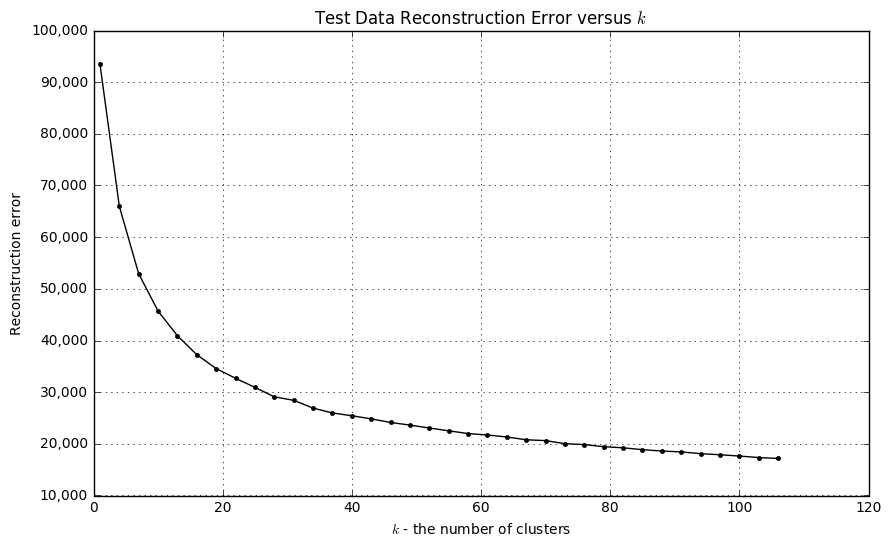

In [7]:
reconstruction_error = np.array(reconstruction_error, dtype = np.float64)
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(k_range, reconstruction_error, '.k-')
ax.grid(True)
ax.set_ylabel('Reconstruction error')
ax.set_xlabel('$k$ - the number of clusters')
ax.set_title('Test Data Reconstruction Error versus $k$')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, pos : format(int(y), ',')))
fig.show()

Qualitatively, $100$ looks good to me. Now, let's fit our RBF network, which is a super simple [neural network](https://en.wikipedia.org/wiki/Radial_basis_function_network). We have 1 hidden layer of 100 units with the RBF activation function, and we run a linear regression on that hidden layer. 

In [8]:
n_clusters = 100
kMeansModel = cluster.KMeans(n_clusters = n_clusters, init = 'k-means++', algorithm = 'elkan', precompute_distances = True)
kMeansModel.fit(X_scaled)
prototypes = kMeansModel.cluster_centers_

The RBF kerneal is

\begin{equation}
\kappa(\mathbf{x}, \mathbf{x}^\prime) = \exp\left(-\frac{\lVert\mathbf{x}-\mathbf{x}^\prime\rVert^2}{2\sigma^2}\right),
\end{equation}

so we'll perform our linear regression with design matrix $\Phi$, where rows of $\Phi$ are

\begin{equation}
\phi(\mathbf{x}) = \begin{pmatrix}
\kappa(\mathbf{x}, \boldsymbol\mu_1) & \kappa(\mathbf{x}, \boldsymbol\mu_2) & \cdots 
& \kappa(\mathbf{x}, \boldsymbol\mu_{k})
\end{pmatrix},
\end{equation}

where the $\boldsymbol\mu_j$ for $j = 1,2,\ldots,k$ are our cluster centers. $\sigma^2$ is parameter called *bandwidth* that we'll have to find with cross-validation.

In [9]:
from sklearn import model_selection

class RBFNetwork:
    """
    Implements RBFNetwork as a special case of linear regression.
    """
    def __init__(self, mu, sigma2):
        self.linearRegressor = linear_model.LinearRegression(fit_intercept = True, normalize = False)
        self.mu = mu
        self.sigma2 = sigma2
    
    def fit(self, X, y):
        Phi = self.rbf_transform(X, self.mu, self.sigma2)
        linearRegressor.fit(Phi, y)
        return self
    
    def predict(self, X):
        Phi = self.rbf_transform(X, self.mu, self.sigma2)
        return linearRegressor.predict(Phi)
        
    def score(self, X, y):
        predicted_y = self.predict(X)
        return -(sum((y - predicted_y)**2)/len(y))[0]         
    
    def get_params(self, deep = True):
        return {'mu': self.mu, 'sigma2': self.sigma2}
    
    def set_params(self, **params):
        if 'mu' in params:
            self.mu = params['mu']
        if 'sigma2' in params:
            self.sigma2 = params['sigma2']
        return self
    
    @staticmethod
    def rbf(x1, x2, sigma2):
        deltaX = (x1 - x2)
        distX = sum(deltaX*deltaX)
        return np.exp(-distX/2/sigma2)
    
    @staticmethod
    def phi(x, mu, sigma2):
        return np.apply_along_axis(func1d = RBFNetwork.rbf, axis = 1, arr = mu, x2 = x, sigma2 = sigma2)
    
    @staticmethod
    def rbf_transform(X, mu, sigma2):
        return np.apply_along_axis(func1d = RBFNetwork.phi, axis = 1, arr = X, mu = mu, sigma2 = sigma2)


bandwidths = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
gridSearchCV = model_selection.GridSearchCV(RBFNetwork(mu = prototypes, sigma2 = 1024),
                                            param_grid = {'sigma2': bandwidths},
                                            cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 2016),
                                            n_jobs = 1) ## parallel jobs are broken for a reason that I don't feel like debugging
gridSearchCV.fit(X_scaled, Y_scaled)
cv_results = pd.DataFrame({'bandwidth': bandwidths,
                           'mean_test_score': gridSearchCV.cv_results_['mean_test_score'],
                           'std_test_score': gridSearchCV.cv_results_['std_test_score'],
                           'mean_train_score': gridSearchCV.cv_results_['mean_train_score'],
                           'std_train_score': gridSearchCV.cv_results_['std_train_score']})
cv_results

,bandwidth,mean_test_score,mean_train_score,std_test_score,std_train_score
0,1,-267.152902,-265.932425,15.279617,3.813405
1,2,-188.522188,-187.648077,11.168259,2.790824
2,4,-122.894823,-122.112400,6.091327,1.522200
3,8,-72.431290,-71.858192,2.480018,0.620141
4,16,-40.163809,-39.825444,0.767083,0.193418
5,32,-25.264711,-25.057333,0.227940,0.056388
6,64,-20.167603,-20.004292,0.097739,0.025807
7,128,-18.716779,-18.568064,0.192818,0.049968
8,256,-18.422612,-18.277355,0.228230,0.058791
9,512,-18.432984,-18.287904,0.238813,0.061415


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


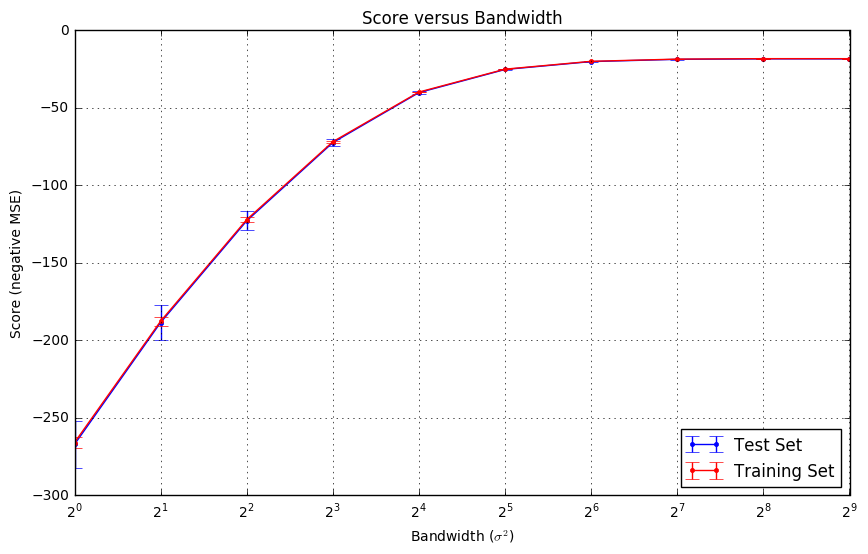

In [10]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
test_error_bars = ax.errorbar(cv_results['bandwidth'], cv_results['mean_test_score'], cv_results['std_test_score'],
                              linestyle='-', marker='.', color='b', capsize=5)
train_error_bars = ax.errorbar(cv_results['bandwidth'], cv_results['mean_train_score'], cv_results['std_train_score'],
                              linestyle='-', marker='.', color='r', capsize=5)
ax.grid(True)
ax.legend([test_error_bars, train_error_bars], ['Test Set', 'Training Set'], loc='lower right')
ax.set_xscale('log', basex = 2)
ax.set_xlabel('Bandwidth ($\sigma^2$)')
ax.set_ylabel('Score (negative MSE)')
ax.set_title('Score versus Bandwidth')
fig.show()

It looks like the best model has a bandwidth of about $2^{8}$. Let's compute its SMSE.

In [11]:
rBFNetwork = RBFNetwork(mu = prototypes, sigma2 = 2**8)
rBFNetwork.fit(X_scaled, Y_scaled)
-rBFNetwork.score(X_scaled_test, Y_scaled_test)/np.var(Y_scaled, ddof=0)

0.042844306703931787

Seems that we can only get down to an SMSE of 0.043. The next step is to try a neural network. This has more parameters to choose. In particular, we're interested in the number of hidden units, layers, and the L2 regularization parameter.

## Neural Networks with TensorFlow

Since I work at Google, I thought that I would demonstrate constructing a neural network in [TensorFlow](https://www.tensorflow.org/). Since I'm doing this with the intent of learning the details of the models, I'm going to eschew the high-level APIs and construct the graph mostly by hand. Much of the code is imported from [`sarco_train.py`](https://github.com/ppham27/MLaPP-solutions/blob/master/chap16/sarco_train.py).

First, we'll set up our features which need to normalized. We make it so that the input has mean 0 and variance 1.

In [6]:
import tensorflow as tf
from sarco_train import create_feature_columns

feature_columns = create_feature_columns(pd.concat([training_data, test_data]))

def get_feature_data(data, feature_columns):
    graph = tf.Graph()
    with graph.as_default():
        features = {column: tf.constant(column_data, dtype=tf.float32)
                    for column, column_data in data.to_dict('list').items()}
        input_layer = tf.feature_column.input_layer(
            features=features, feature_columns=feature_columns)
    with tf.Session(graph=graph) as sess:
        input_data = sess.run(input_layer)
    return input_data, data[TARGET_COLUMN].astype(np.float32)

training_input_data, training_target_data = get_feature_data(training_data, feature_columns)
test_input_data, test_target_data = get_feature_data(test_data, feature_columns)

## Building the Graph

Everything in TensorFlow is a graph. We build build it layer by layer.

### Input Layer

Here, we extract the features from the training data and test data and apply the feature columns to the two datasets.

### Inference Layer

Now, we can think about the inference layer. To keep things rather simple, I'll only use two layers. The weights and biases are initialize with noise, ReLU is used as the activation function. The first layer has 70 units, and the second layer has 50 units. Since we have an input of 21 features, the total number of weight parameters in a fully connected network are $21 \times 70 + 70 \times 50 + 50 \times 1$, and we have also have $70 + 50 + 1$ bias parameters. The number of units was chosen arbitrarily. I was too lazy to implement and cross validation strategy.

### Loss Layer

For loss, we minimize mean squared error. This is we'll compare models.

In [7]:
from sarco_train import inference, HIDDEN1_UNITS, HIDDEN2_UNITS

eval_graph = tf.Graph()
with eval_graph.as_default():    
    input = tf.placeholder(dtype=tf.float32, shape=(None, len(feature_columns)))
    prediction = inference(input, HIDDEN1_UNITS, HIDDEN2_UNITS)
    
    labels = tf.placeholder(dtype=tf.float32, shape=(None,))
    mse = tf.losses.mean_squared_error(labels=labels, predictions=prediction, reduction=tf.losses.Reduction.MEAN)
        
    tf.summary.scalar('mse', mse)
    
    summary_op = tf.summary.merge_all()
# Reset evaluation process
last_checkpoint_summarized = None

## Training the Model

Training the model is done in [`sarco_train.py`](https://github.com/ppham27/MLaPP-solutions/blob/master/chap16/sarco_train.py). The script was run with the command:

`python3 sarco_train.py --restart --log_level=INFO --log_dir /Users/phillypham/tmp/sarco/logs`

Input is fetched from a queue to avoid blocking the thread doing the training. 1024 examples are processed in each training step. In addition to minimize mean squared error, we add $L^1$ and $L^2$ regularization to deal with the large number of parameters. The scale parameter for $L^1$ was $1.0$. The scale parameter for $L^2$ is $14.0$. The variation of gradient descent that we'll use is [Adam Optimizer](https://arxiv.org/abs/1412.6980) with a learning rate of $0.01$.

While the training script is running, this code runs in a separate process to periodically evaluate the model. We calculate mean squared error against the entire training set and entire test set. We can see these plotted by running `tensorboard --logdir=/Users/phillypham/tmp/sarco/logs` and visiting [TensorBoard](http://localhost:6006).

Since we're using a [Monitored Session](https://www.tensorflow.org/versions/master/api_docs/python/tf/train/MonitoredSession), we can continue training from where left off by running

`python3 sarco_train.py --log_level=INFO --log_dir /Users/phillypham/tmp/sarco/logs`

and restarting the evaluation code below.

In [8]:
from sarco_train import CHECKPOINT_INTERVAL_SECS

CHECKPOINT_DIR = '/Users/phillypham/tmp/sarco/logs'
EVAL_DIR = CHECKPOINT_DIR + '/eval'

with eval_graph.as_default():
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
    
    training_writer = tf.summary.FileWriter(EVAL_DIR + '/training', eval_graph)
    test_writer = tf.summary.FileWriter(EVAL_DIR + '/test', eval_graph)
    with tf.Session() as sess:           
        def write_summary(step):
            def write_mse(writer, features, target):
                summary = sess.run(summary_op, feed_dict={input: features, labels: target})
                writer.add_summary(summary, step)
                writer.flush()
            tf.logging.info('Writing summary for step {:d}'.format(step))
            write_mse(test_writer, test_input_data, test_target_data)
            write_mse(training_writer, training_input_data, training_target_data)
        while True:
            checkpoint_state = tf.train.get_checkpoint_state(CHECKPOINT_DIR)
            checkpoint_path = checkpoint_state.model_checkpoint_path
            # Stop running when no more new checkpoints are being generated.
            if checkpoint_path == last_checkpoint_summarized:
                break
            saver.restore(sess, checkpoint_state.model_checkpoint_path)
            global_step = int(checkpoint_state.model_checkpoint_path.split('/')[-1].split('-')[-1])                   
            write_summary(global_step)
            last_checkpoint_summarized = checkpoint_path
            time.sleep(CHECKPOINT_INTERVAL_SECS)
        tf.logging.info('Training stopped.')

INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-1
INFO:tensorflow:Writing summary for step 1
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-1678
INFO:tensorflow:Writing summary for step 1678
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-3364
INFO:tensorflow:Writing summary for step 3364
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-5052
INFO:tensorflow:Writing summary for step 5052
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-6742
INFO:tensorflow:Writing summary for step 6742
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-8430
INFO:tensorflow:Writing summary for step 8430
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-10121
INFO:tensorflow:Writing summary for step 10121
INFO:tensorflow:Restoring parameters from /Us

INFO:tensorflow:Writing summary for step 99478
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-101169
INFO:tensorflow:Writing summary for step 101169
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-102850
INFO:tensorflow:Writing summary for step 102850
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-104538
INFO:tensorflow:Writing summary for step 104538
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-106225
INFO:tensorflow:Writing summary for step 106225
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-107909
INFO:tensorflow:Writing summary for step 107909
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-109595
INFO:tensorflow:Writing summary for step 109595
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-111286
INFO:tensorflo

INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-199109
INFO:tensorflow:Writing summary for step 199109
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-200812
INFO:tensorflow:Writing summary for step 200812
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-202527
INFO:tensorflow:Writing summary for step 202527
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-204216
INFO:tensorflow:Writing summary for step 204216
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-205901
INFO:tensorflow:Writing summary for step 205901
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-207596
INFO:tensorflow:Writing summary for step 207596
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-209288
INFO:tensorflow:Writing summary for step 209288
INFO:tensorfl

INFO:tensorflow:Writing summary for step 297332
INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-298176
INFO:tensorflow:Writing summary for step 298176
INFO:tensorflow:Training stopped.


In TensorBoard, I've been summarizing loss and the mean squared error on checkpoints as the model is training. Here's the loss plotted.

![Batch Loss](nn_batch_loss.png)

You can see that the model has more or less by converged 50,000 training steps. Because we're sampling batches of data, there's a lot of noise.

The loss includes the regularization penalty, so when evaluating the model on the test data, it may be more helpful to look at mean squared error. The various mean squared errors are:
- **Orange**: Batch that we're training on
- **Blue**: The test set
- **Purple**: The training set

![MSE](nn_mse_all.png)

Of course, this isn't very helpful because of how noisy the MSE of the training batch set is. It's more helpful to look at just the MSEs from the evaluation process.

![Evaluation MSEs](nn_mse_eval.png)

After the model converged, there's a lot of random noise. We may possibly be overfitting by training this long. The MSE on the training and test set stay pretty close together, however. It looks like the lowest MSE is obtained by the model at step 188,939. Le

In [9]:
SELECTED_MODEL = CHECKPOINT_DIR + '/model.ckpt-217750'

with eval_graph.as_default():
    with tf.Session() as sess:
        saver.restore(sess, SELECTED_MODEL)
        test_mse = sess.run(mse, feed_dict={input: test_input_data, labels: test_target_data})
        log_mse(test_mse)

INFO:tensorflow:Restoring parameters from /Users/phillypham/tmp/sarco/logs/model.ckpt-217750
MSE: 9.3451519012
SMSE: 0.0223142085


Nice. Neural networks achieve the best standarded mean squared error. Of course, training this model took the longest, and the details of why it works are already obscure after only two layers.